# Index-Free Grover Search Implementation via QROM Based State Encoding for Quantum Pattern Search

This notebook contains the code used in the pre-print paper:
**"Paper Title" (Author et al., 2025)**

It demonstrates:
- Data loading and preprocessing  
- Model architecture  
- Training procedure  
- Evaluation metrics  
- Reproducing main results  

Please see the README for environment setup and dependencies.


The Notebook contains three codes:
1. Index Matched Code
2. Index-Free Code (numerical)
3. Index-Free DNA Pattern Search in DNA Sequence

In [16]:
# Version Check

import pennylane as qml
import numpy as np
import matplotlib

print(f""" 
    Pennylane  : {qml.__version__}
    NumPy      : {np.__version__}
    Matplotlib : {matplotlib.__version__}

""")

 
    Pennylane  : 0.43.1
    NumPy      : 2.3.5
    Matplotlib : 3.10.7




# 1. Using Marked State

In [1]:
import pennylane as qml

import matplotlib.pyplot as plt
import numpy as np

## [Step 1] Preparing the Initial State

In [2]:
NUM_QUBITS = 2
dev = qml.device("default.qubit", wires=NUM_QUBITS)
wires = list(range(NUM_QUBITS))

In [3]:
def equal_superposition(wires):
    for wire in wires:
        qml.Hadamard(wires=wire)

In [4]:
@qml.qnode(dev)
def circuit():
    qml.Snapshot("Initial state")
    equal_superposition(wires)
    qml.Snapshot("After applying the Hadamard gates")
    return qml.probs(wires=wires)  # Probability of finding a computational basis state on the wires

In [5]:
results = qml.snapshots(circuit)()

for k, result in results.items():
    print(f"{k}: {result}")

Initial state: [1.+0.j 0.+0.j 0.+0.j 0.+0.j]
After applying the Hadamard gates: [0.5+0.j 0.5+0.j 0.5+0.j 0.5+0.j]
execution_results: [0.25 0.25 0.25 0.25]


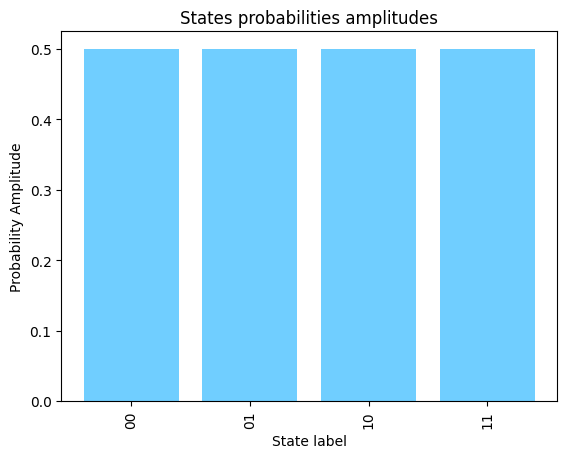

In [6]:
y = np.real(results["After applying the Hadamard gates"])
bit_strings = [f"{x:0{NUM_QUBITS}b}" for x in range(len(y))]

plt.bar(bit_strings, y, color = "#70CEFF")

plt.xticks(rotation="vertical")
plt.xlabel("State label")
plt.ylabel("Probability Amplitude")
plt.title("States probabilities amplitudes")
plt.show()

## [Step 2] The Oracle and Grover’s diffusion operator

In [7]:
dev = qml.device("default.qubit", wires=NUM_QUBITS)

In [8]:
@qml.qnode(dev)
def circuit():
    qml.Snapshot("Initial state |00>")
    qml.FlipSign([0, 0], wires=wires)
    qml.Snapshot("After flipping it")
    return qml.state()

In [9]:
results = qml.snapshots(circuit)()

for k, result in results.items():
    print(f"{k}: {result}")

Initial state |00>: [1.+0.j 0.+0.j 0.+0.j 0.+0.j]
After flipping it: [-1.+0.j  0.+0.j  0.+0.j  0.+0.j]
execution_results: [-1.+0.j  0.+0.j  0.+0.j  0.+0.j]


In [10]:
y1 = np.real(results["Initial state |00>"])
y2 = np.real(results["After flipping it"])

In [11]:
bit_strings = [f"{x:0{NUM_QUBITS}b}" for x in range(len(y))]

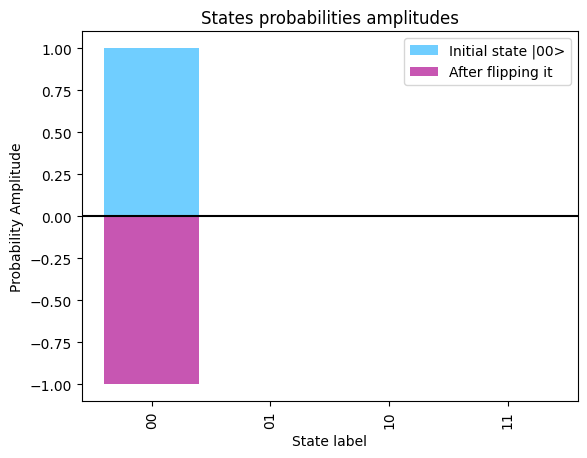

In [12]:
plt.bar(bit_strings, y1, color = "#70CEFF")
plt.bar(bit_strings, y2, color = "#C756B2")

plt.xticks(rotation="vertical")
plt.xlabel("State label")
plt.ylabel("Probability Amplitude")
plt.title("States probabilities amplitudes")

plt.legend(["Initial state |00>", "After flipping it"])
plt.axhline(y=0.0, color="k", linestyle="-")
plt.show()

In [13]:
omega = np.zeros(NUM_QUBITS)

In [14]:
def oracle(wires, omega):
    qml.FlipSign(omega, wires=wires)

dev = qml.device("default.qubit", wires=NUM_QUBITS)

In [15]:
@qml.qnode(dev)
def circuit():
    equal_superposition(wires)
    qml.Snapshot("Before querying the Oracle")

    oracle(wires, omega)
    qml.Snapshot("After querying the Oracle")

    return qml.probs(wires=wires)

In [16]:
results = qml.snapshots(circuit)()

for k, result in results.items():
    print(f"{k}: {result}")

Before querying the Oracle: [0.5+0.j 0.5+0.j 0.5+0.j 0.5+0.j]
After querying the Oracle: [-0.5+0.j  0.5+0.j  0.5+0.j  0.5+0.j]
execution_results: [0.25 0.25 0.25 0.25]


In [17]:
y1 = np.real(results["Before querying the Oracle"])
y2 = np.real(results["After querying the Oracle"])

In [18]:
bit_strings = [f"{x:0{NUM_QUBITS}b}" for x in range(len(y1))]

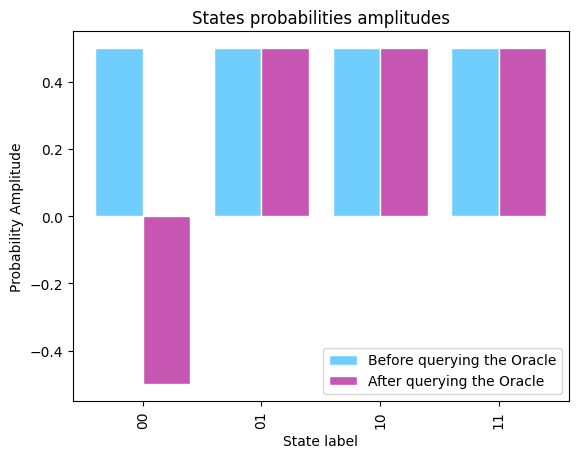

In [19]:
bar_width = 0.4

rect_1 = np.arange(0, len(y1))
rect_2 = [x + bar_width for x in rect_1]

plt.bar(
    rect_1,
    y1,
    width=bar_width,
    edgecolor="white",
    color = "#70CEFF",
    label="Before querying the Oracle",
)
plt.bar(
    rect_2,
    y2,
    width=bar_width,
    edgecolor="white",
    color = "#C756B2",
    label="After querying the Oracle",
)

plt.xticks(rect_1 + 0.2, bit_strings, rotation="vertical")
plt.xlabel("State label")
plt.ylabel("Probability Amplitude")
plt.title("States probabilities amplitudes")

plt.legend()
plt.show()

In [20]:
dev = qml.device("default.qubit", wires=NUM_QUBITS)

In [21]:
def diffusion_operator(wires):
    for wire in wires:
        qml.Hadamard(wires=wire)
        qml.PauliZ(wires=wire)
    qml.ctrl(qml.PauliZ, 0)(wires=1)
    for wire in wires:
        qml.Hadamard(wires=wire)

In [22]:
@qml.qnode(dev)
def circuit():
    equal_superposition(wires)
    qml.Snapshot("Uniform superposition |s>")

    oracle(wires, omega)
    qml.Snapshot("State marked by Oracle")
    diffusion_operator(wires)

    qml.Snapshot("Amplitude after diffusion")
    return qml.probs(wires=wires)

In [23]:
results = qml.snapshots(circuit)()

for k, result in results.items():
    print(f"{k}: {result}")

Uniform superposition |s>: [0.5+0.j 0.5+0.j 0.5+0.j 0.5+0.j]
State marked by Oracle: [-0.5+0.j  0.5+0.j  0.5+0.j  0.5+0.j]
Amplitude after diffusion: [1.+0.j 0.+0.j 0.+0.j 0.+0.j]
execution_results: [1. 0. 0. 0.]


## [Step 3] Searching for more items in a bigger list

In [24]:
NUM_QUBITS = 5

omega = np.array([np.zeros(NUM_QUBITS), np.ones(NUM_QUBITS)])

M = len(omega)
N = 2**NUM_QUBITS
wires = list(range(NUM_QUBITS))

In [25]:
dev = qml.device("default.qubit", wires=NUM_QUBITS)

In [26]:
@qml.qnode(dev)
def circuit():
    iterations = int(np.round(np.sqrt(N / M) * np.pi / 4))

    # Initial state preparation
    equal_superposition(wires)

    # Grover's iterator
    for _ in range(iterations):
        for omg in omega:
            oracle(wires, omg)
        qml.templates.GroverOperator(wires)

    return qml.probs(wires=wires)

In [27]:
results = qml.snapshots(circuit)()

for k, result in results.items():
    print(f"{k}: {result}")

execution_results: [0.48065948 0.00128937 0.00128937 0.00128937 0.00128937 0.00128937
 0.00128937 0.00128937 0.00128937 0.00128937 0.00128937 0.00128937
 0.00128937 0.00128937 0.00128937 0.00128937 0.00128937 0.00128937
 0.00128937 0.00128937 0.00128937 0.00128937 0.00128937 0.00128937
 0.00128937 0.00128937 0.00128937 0.00128937 0.00128937 0.00128937
 0.00128937 0.48065948]


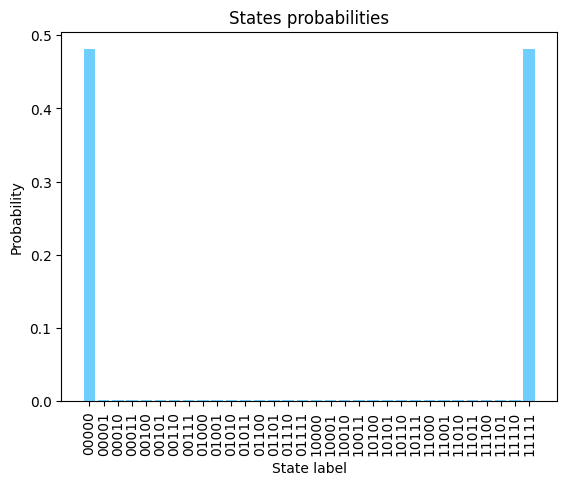

In [28]:
y = results["execution_results"]
bit_strings = [f"{x:0{NUM_QUBITS}b}" for x in range(len(y))]

plt.bar(bit_strings, results["execution_results"], color = "#70CEFF")

plt.xticks(rotation="vertical")
plt.xlabel("State label")
plt.ylabel("Probability")
plt.title("States probabilities")

plt.show()

# 2. Complete Random Number Implementation

In [1]:
import pennylane as qml
from pennylane import numpy as np

from src.visualize.num_visualize import ss_hist_visualize, ls_hist_visualize

In [2]:
# Run only one of this.

scale = int(input("0 for Small Scale, and 1 for Large Scale"))

if scale == 0:
    # Small Scale
    my_list = [19, 100, 108, 33]
    target_value = 108
elif scale == 1:
    # Large Scale
    N = 1024
    np.random.seed(42)
    my_list = np.random.randint(0, 1024, size=N).tolist()
    target_value = my_list[50]  
else:
    print("0 for small scale, 1 for large scale")

0 for Small Scale, and 1 for Large Scale 1


In [3]:
addr_n = int(np.ceil(np.log2(len(my_list))))        
data_n = int(np.ceil(np.log2(max(my_list) + 1)))    
total_qubits = addr_n + data_n

dev = qml.device("default.qubit", wires=total_qubits, shots=None)

print(f""" 
    Address Qubit: {addr_n}
    Data Qubit   : {data_n}
    Total Qubit  : {total_qubits}
""")

 
    Address Qubit: 10
    Data Qubit   : 10
    Total Qubit  : 20



In [4]:
def encode_value(addr_state, value):
    """
    Encode value into data register controlled by address
    """
    addr_bits = f"{addr_state:0{addr_n}b}"
    value_bits = f"{value:0{data_n}b}"
    
    # Flip address qubits where bit is 0
    for i, bit in enumerate(addr_bits):
        if bit == "0":
            qml.PauliX(i)
    
    # Multi-controlled X to set data qubits
    for data_idx, bit in enumerate(value_bits):
        if bit == "1":
            qml.MultiControlledX(wires=list(range(addr_n)) + [addr_n + data_idx])
    
    # Undo flips on address qubits
    for i, bit in enumerate(addr_bits):
        if bit == "0":
            qml.PauliX(i)

def qram_load():
    for i, val in enumerate(my_list):
        encode_value(i, val)

def qram_unload():
    for i, val in enumerate(my_list):
        encode_value(i, val)


In [5]:
def oracle():
    """
    Oracle construction without solution matching.
    """
    target_bits = f"{target_value:0{data_n}b}"  # MSB first

    # Flip qubits where target bit = 0
    for i, bit in enumerate(target_bits):
        if bit == "0":
            qml.PauliX(addr_n + i)

    # Multi-controlled Z
    data_wires = list(range(addr_n, addr_n + data_n))
    target = data_wires[-1]
    controls = data_wires[:-1]

    qml.Hadamard(target)
    qml.MultiControlledX(wires=controls + [target])
    qml.Hadamard(target)

    # Undo flips
    for i, bit in enumerate(target_bits):
        if bit == "0":
            qml.PauliX(addr_n + i)

In [6]:
def diffuser():
    """
    Diffusor
    """
    # Apply H and X to address qubits
    for i in range(addr_n):
        qml.Hadamard(i)
        qml.PauliX(i)
    
    # Multi-controlled Z on all address qubits
    if addr_n > 1:
        qml.Hadamard(0)
        qml.MultiControlledX(wires=list(range(1, addr_n)) + [0])
        qml.Hadamard(0)
    
    # Undo X and H
    for i in range(addr_n):
        qml.PauliX(i)
        qml.Hadamard(i)

In [7]:
@qml.qnode(dev)
def grover_steps():
    """
    Iteration Steps
    """
    amplitudes = []

    # Step 0: Initial state
    for i in range(addr_n):
        qml.Hadamard(i)
    amplitudes.append(qml.state())

    # Step 1: QRAM load + Oracle 1
    qram_load()
    oracle()
    amplitudes.append(qml.state())

    # Step 2: Diffuser 1
    qram_unload()
    diffuser()
    amplitudes.append(qml.state())

    # Step 3: Oracle 2
    qram_load()
    oracle()
    amplitudes.append(qml.state())

    # Step 4: Diffuser 2
    qram_unload()
    diffuser()
    amplitudes.append(qml.state())

    return amplitudes

In [8]:
@qml.qnode(dev)
def grover_probs():
    """
    
    """
    # Superposition over addresses
    for i in range(addr_n):
        qml.Hadamard(i)

    qram_load()
    oracle()
    qram_unload()
    diffuser()

    return qml.probs(wires=range(addr_n))

In [9]:
probability = grover_probs()

In [10]:
for idx, p in enumerate(probability):
    print(f"Address {idx:0{addr_n}b} (decimal {idx}): probability = {p}")

Address 0000000000 (decimal 0): probability = 0.000968948006629938
Address 0000000001 (decimal 1): probability = 0.000968948006629938
Address 0000000010 (decimal 2): probability = 0.000968948006629938
Address 0000000011 (decimal 3): probability = 0.000968948006629938
Address 0000000100 (decimal 4): probability = 0.000968948006629938
Address 0000000101 (decimal 5): probability = 0.000968948006629938
Address 0000000110 (decimal 6): probability = 0.000968948006629938
Address 0000000111 (decimal 7): probability = 0.000968948006629938
Address 0000001000 (decimal 8): probability = 0.000968948006629938
Address 0000001001 (decimal 9): probability = 0.000968948006629938
Address 0000001010 (decimal 10): probability = 0.000968948006629938
Address 0000001011 (decimal 11): probability = 0.000968948006629938
Address 0000001100 (decimal 12): probability = 0.000968948006629938
Address 0000001101 (decimal 13): probability = 0.000968948006629938
Address 0000001110 (decimal 14): probability = 0.000968948

Target at index: 50
Success probability: 0.0087661892


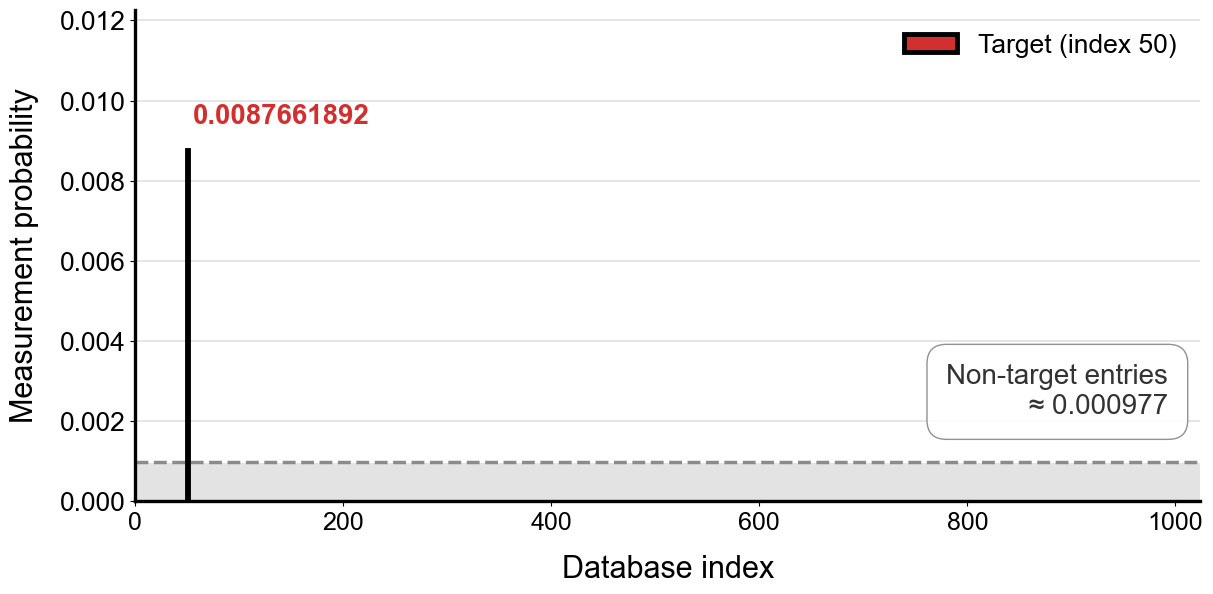

In [11]:
if scale == 0: 
    ss_hist_visualize(probability)
elif scale == 1:
    ls_hist_visualize(probability)
else:
    print("Wrong scale choice")

### Step by Step Oracle Visualization for Small Scale N = 4

In [40]:
if scale == 0: 
    # Testing Functions
    @qml.qnode(dev)
    def step0():
        # Initial superposition
        for i in range(addr_n):
            qml.Hadamard(i)
        return qml.state()
    
    @qml.qnode(dev)
    def step1():
        # Superposition + QRAM + Oracle
        for i in range(addr_n):
            qml.Hadamard(i)
        qram_load()
        oracle()
        return qml.state()
    
    @qml.qnode(dev)
    def step2():
        # Superposition + QRAM + Oracle + QRAM unload + Diffuser
        for i in range(addr_n):
            qml.Hadamard(i)
        qram_load()
        oracle()
        qram_unload()
        diffuser()
        return qml.state()
    
    # Testing Code
    states = [step0(), step1(), step2()]
    
    for step, state in enumerate(states):
        print(f"\nStep {step}:")
        for idx in range(2**addr_n):
            # Sum out the data qubits to get address amplitudes
            amplitude = 0
            for data_state in range(2**data_n):
                full_idx = idx * (2**data_n) + data_state
                amplitude += state[full_idx]
            print(f"Address {idx:0{addr_n}b}: {amplitude:}")

# 3. Implementing for 1 Nucleotide Base Search in a DNA Sequence

In [18]:
import pennylane as qml
from pennylane.drawer import draw_mpl
import matplotlib.pyplot as plt
import math

from src.visualize.dna_visualize import ss_hist_visualize, ls_hist_visualize

In [19]:
dna_bits = {"A":"00", "C":"01", "G":"10", "T":"11"}

dna_bits_inv = {v:k for k,v in dna_bits.items()}

In [20]:
def encode_nucleotide(n):
    """Encode single nucleotide into integer 0–3."""
    return int(dna_bits[n], 2)

def encode_dna_sequence(seq):
    """Encode DNA sequence (e.g., 'AGTC') into an integer."""
    bitstring = "".join(dna_bits[ch] for ch in seq)
    return int(bitstring, 2)

def decode_dna_integer(val, length):
    """Decode an integer back into a DNA string of given length."""
    bitstring = f"{val:0{2*length}b}"  # 2 bits per nucleotide
    return "".join(dna_bits_inv[bitstring[i:i+2]] for i in range(0, len(bitstring), 2))

In [21]:
class DNAOneNucleotideGroverSearch:
    """
    QGroverSearch CLASS
    """
    def __init__(self, my_list, target_value, addr_n=None, data_n=None):
        self.my_list = my_list
        self.target_value = target_value
        
        N = len(my_list)
        max_val = max(my_list) if my_list else 0
        
        self.addr_n = addr_n if addr_n is not None else math.ceil(math.log2(N))
        self.data_n = data_n if data_n is not None else math.ceil(math.log2(max_val + 1))
        
        self.num_iterations = max(1, int(round((math.pi/4) * math.sqrt(N))))

        if 2**self.addr_n < N:
            raise ValueError("Address register size too small.")
        
        self.total_qubits = self.addr_n + self.data_n
        self.dev = qml.device("default.qubit", wires=self.total_qubits, shots=None)
        self.grover_probs_qnode = qml.QNode(self._grover_probs_circuit, self.dev)

    # --- QRAM building ---
    def qubit_status(self):
        return self.addr_n, self.data_n, self.num_iterations
    
    def _encode_value(self, addr_state, value):
        addr_bits = f"{addr_state:0{self.addr_n}b}"
        value_bits = f"{value:0{self.data_n}b}"

        for i, bit in enumerate(addr_bits):
            if bit == "0":
                qml.PauliX(i)

        for data_idx, bit in enumerate(value_bits):
            if bit == "1":
                qml.MultiControlledX(
                    wires=list(range(self.addr_n)) + [self.addr_n + data_idx]
                )

        for i, bit in enumerate(addr_bits):
            if bit == "0":
                qml.PauliX(i)

    def _qram_load(self):
        for i, val in enumerate(self.my_list):
            self._encode_value(i, val)

    def _qram_unload(self):
        for i, val in reversed(list(enumerate(self.my_list))):
            self._encode_value(i, val)

    # --- Oracle ---
    
    def _oracle(self):
        target_bits = f"{self.target_value:0{self.data_n}b}"

        for i, bit in enumerate(target_bits):
            if bit == "0":
                qml.PauliX(self.addr_n + i)

        data_wires = list(range(self.addr_n, self.addr_n + self.data_n))
        
        if self.data_n == 1:
            qml.PauliZ(data_wires[0])
        else:
            target = data_wires[-1]
            controls = data_wires[:-1]
            qml.Hadamard(target)
            qml.MultiControlledX(wires=controls + [target])
            qml.Hadamard(target)

        for i, bit in enumerate(target_bits):
            if bit == "0":
                qml.PauliX(self.addr_n + i)

    # --- Diffuser ---
    
    def _diffuser(self):
        for i in range(self.addr_n):
            qml.Hadamard(i)
            qml.PauliX(i)

        if self.addr_n == 1:
            qml.PauliZ(0)
        else:
            controls = list(range(self.addr_n - 1))
            target = self.addr_n - 1
            qml.Hadamard(target)
            qml.MultiControlledX(wires=controls + [target])
            qml.Hadamard(target)

        for i in range(self.addr_n):
            qml.PauliX(i)
            qml.Hadamard(i)

    # --- Full circuit ---
    
    def _grover_probs_circuit(self):
        for i in range(self.addr_n):
            qml.Hadamard(i)

        self._qram_load()
        self._oracle()
        self._qram_unload()
        self._diffuser()
        return qml.probs(wires=range(self.addr_n))

    # --- Run ---
    
    def run(self):
        probs = self.grover_probs_qnode()
        
        res = {}
        for idx, p in enumerate(probs):
            # print(f"Address {idx}: Prob={p:.4f}")
            res[idx] = p
        return res

    def _draw(self, circuit_func, title="", save_as=None):
            """Internal helper to draw any subcircuit."""
            @qml.qnode(self.dev)
            def wrapper():
                circuit_func()
                return qml.state()
            
            # --- Adaptive Width Calculation (Recap) ---
            base_width = 8 
            width_per_qubit = self.total_qubits / 2
            adaptive_factor = 4 + 2 * self.addr_n 
            
            fig_width = base_width + width_per_qubit * adaptive_factor
            fig_height = self.total_qubits * 1.5 
    
            # Set a minimum large width for the full circuit to prevent compression
            if 'full' in title.lower():
                 fig_width = max(fig_width, 30) 
            # --- End Adaptive Width Calculation ---
    
            # 💡 KEY CHANGE: Increase the fontsize from 13 to 18 (or another value)
            fig, ax = draw_mpl(wrapper, 
                               style="black_white", 
                               fontsize=30,           # <--- INCREASED FONT SIZE HERE
                               title=title, 
                               wire_options={'linewidth': 1.0},
                               box_options={'facecolor': 'lavender', 'edgecolor': 'black', 'linewidth': 1.0})()
            
            fig.set_size_inches(fig_width, fig_height) 
            plt.tight_layout(pad=0.5) 
            
            if save_as:
                fig.savefig(save_as, format='pdf', dpi=600, bbox_inches="tight")
                print(f"→ Saved: {save_as}")
            plt.show()

    def draw_full_circuit(self):
        """Draw the complete Grover iteration (most important figure)"""
        fn = "ss"
        if scale == 1:
            fn = "ls"
            
        def full():
            for i in range(self.addr_n): qml.Hadamard(i)
            self._qram_load()
            self._oracle()
            self._qram_unload()
            self._diffuser()
        self._draw(full, title="Full Index-Free Grover Search Circuit (QROM-based)", 
                  save_as=f"figures/dna/{fn}_full_grover_circuit.pdf")

    # =========== DRAW ================= #
    def draw_qrom(self):
        """Draw only the QROM loading part"""
        fn = "ss"
        if scale == 1:
            fn = "ls"
            
        def qrom():
            for i in range(self.addr_n): qml.Hadamard(i)
            self._qram_load()
        self._draw(qrom, title="QROM: Loading DNA Database into Superposition", 
                  save_as=f"figures/dna/{fn}_qrom_circuit.pdf")

    def draw_oracle(self):
        """Draw oracle (with QROM load so controls are visible)"""
        fn = "ss"
        if scale == 1:
            fn = "ls"
            
        def oracle():
            for i in range(self.addr_n): qml.Hadamard(i)
            self._qram_load()
            self._oracle()
        self._draw(oracle, title="Phase Oracle (marks target nucleotide)", 
                  save_as=f"figures/dna/{fn}_oracle_circuit.pdf")

    def draw_diffuser(self):
        """Draw only the diffusion operator"""
        fn = "ss"
        if scale == 1:
            fn = "ls"
            
        def diffuser():
            self._diffuser()
        self._draw(diffuser, title="Grover Diffusion Operator (address register only)", 
                  save_as=f"figures/dna/{fn}_diffuser_circuit.pdf")


In [22]:
scale = int(input("0 for small scale, and 1 for large scale"))

if scale == 0:
    dna = "AGGTCCT"
    target_dna = "T"
elif scale == 1:
    dna = (
        "ATGGATCCACCCAACGCCGAATATCAACCCGCTGGCCTATTTAGGAGCACCTCATCGTGCCTACGCTCCTACG"
        "GGCACCCTGGCTGCCAGTAACCACCCCCCGCTAAGTTTCACCAATCATTCCTCCACATCACCCTGAAGATATA"
        "CCTCGGTTTGCGGGCCTCAGTAGAAGAGAAAGGTCTGGTACTGATTTCAGCGGCCATCGTTGATACTCATGCC"
        "CTGGCATTCACACTATTCGGAGCGATTGTCGCTGAAGTTGAAGGAATACCGTTCATACTGTTCTTCCCTTCAT"
        "TTCATTATCGCAATACTCCCAATGATATATTTACAGCATTTGTAGGACTTGTCGCTATAGCAGCTCTCATACT"
        "TTCCTTAGACATCCTACGAGGAAACCAATCTTCGTCTATTCATCATCGGGAAATGTATCCAACTTCATCACAA"
        "CCGCCTTATATCCTGCACCAATAACCGACACTTTAGGAATTATTCTTTCTATTCTAGCAATGCACCCCCAATT"
        "TCCACATCAAAACCATCGAATGACTATTCGATATTCTACTCATTTAAAGTAATATCTATTCTAGCAGTACTCT"
        "CAACATCTACTTCTCCTGATGCTTCACCGGATCTCCCAATCACCTCTACTGGCATTATTACCGCCTCTGCTCA"
        "GCCGGAACTAGCAGCCGGCTACCTAGAGGACAAATACTATCGTTGCCTAGCCGCCTTCACCCTGGCCACATTA"
        "CCTTCTCTTAGCCTCTCCATTTATTGAAGCAGTCTTAACTGCCCTAGCCATCGGTGCCCTCTTCATTCTTCTT"
        "CTCCTCGGCAATTTTTGCTGGGAACCAACTGATCATCTAAGAAATTTCGGGTTAACTTCCGGCATCATTCACC"
        "ATCACCATCATTAGCCCCATGGGAGCCTATCCAGGACTTATTCCGCTCTTAGCCACCCACCCTAGACAAAGTC"
        "TCGACATCAATACGCTCTATCCTACGGAGCATCAGCGACCTGCAACTAATCATTCTTCATATTCTCGCCTCAT"
        "CATCATCGTGGTCATGGGTCATCTCTATGACTTAAGACTAGATCTTCTAGCCATGAGAAAGTTGTCCGACACG"
        "CTGGTGATTGCTGGGTTTATTCTTTTTATCGCAGTTCCCTGCAGGAGGAGTTGGACATGTCTCACTATGGCTA"
        "AAGTA"
    )
    target_dna = "C"
else:
    print("0 for small scale, and 1 for large scale")

# Encode each nucleotide (0–3)
encoded_dna = [encode_nucleotide(x) for x in dna]

# Search target
encoded_target = encode_nucleotide(target_dna)

print("DNA database:", dna)
print("Encoded:", encoded_dna)
print("Searching for:", target_dna, "encoded as", encoded_target)

0 for small scale, and 1 for large scale 1


DNA database: ATGGATCCACCCAACGCCGAATATCAACCCGCTGGCCTATTTAGGAGCACCTCATCGTGCCTACGCTCCTACGGGCACCCTGGCTGCCAGTAACCACCCCCCGCTAAGTTTCACCAATCATTCCTCCACATCACCCTGAAGATATACCTCGGTTTGCGGGCCTCAGTAGAAGAGAAAGGTCTGGTACTGATTTCAGCGGCCATCGTTGATACTCATGCCCTGGCATTCACACTATTCGGAGCGATTGTCGCTGAAGTTGAAGGAATACCGTTCATACTGTTCTTCCCTTCATTTCATTATCGCAATACTCCCAATGATATATTTACAGCATTTGTAGGACTTGTCGCTATAGCAGCTCTCATACTTTCCTTAGACATCCTACGAGGAAACCAATCTTCGTCTATTCATCATCGGGAAATGTATCCAACTTCATCACAACCGCCTTATATCCTGCACCAATAACCGACACTTTAGGAATTATTCTTTCTATTCTAGCAATGCACCCCCAATTTCCACATCAAAACCATCGAATGACTATTCGATATTCTACTCATTTAAAGTAATATCTATTCTAGCAGTACTCTCAACATCTACTTCTCCTGATGCTTCACCGGATCTCCCAATCACCTCTACTGGCATTATTACCGCCTCTGCTCAGCCGGAACTAGCAGCCGGCTACCTAGAGGACAAATACTATCGTTGCCTAGCCGCCTTCACCCTGGCCACATTACCTTCTCTTAGCCTCTCCATTTATTGAAGCAGTCTTAACTGCCCTAGCCATCGGTGCCCTCTTCATTCTTCTTCTCCTCGGCAATTTTTGCTGGGAACCAACTGATCATCTAAGAAATTTCGGGTTAACTTCCGGCATCATTCACCATCACCATCATTAGCCCCATGGGAGCCTATCCAGGACTTATTCCGCTCTTAGCCACCCACCCTAGACAAAGTCTCGACATCAATACGCTCTATCCTACGGAGCATCAGCG

In [23]:
# Run Grover search
gs = DNAOneNucleotideGroverSearch(encoded_dna, encoded_target)
results = gs.run()

In [24]:
best_address = max(results, key=results.get)

addr_n, data_n, iterations = gs.qubit_status()
print(f""" 

    Address Qubit: {addr_n}
    Data Qubit   : {data_n}
    Total Qubit  : {addr_n + data_n}

    Num_iterations : {iterations}
""")

 

    Address Qubit: 11
    Data Qubit   : 2
    Total Qubit  : 13

    Num_iterations : 27



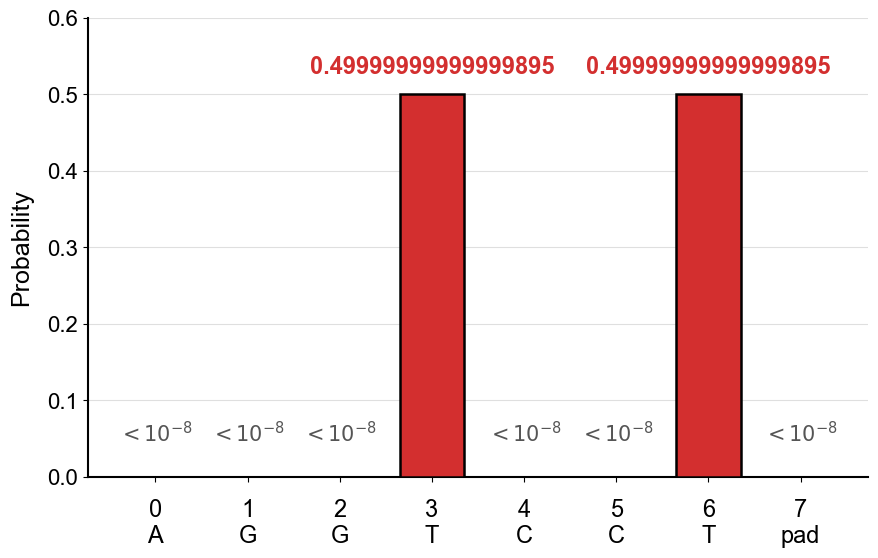

In [58]:
if scale == 0:
    ss_hist_visualize(results)
elif scale == 1:
    ls_hist_visualize(results, dna)
else:
    print("choose scale")

C:\Users\mruna\AppData\Local\Temp\ipykernel_25160\2906484112.py:150: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0.5)


→ Saved: figures/dna/ss_full_grover_circuit.pdf


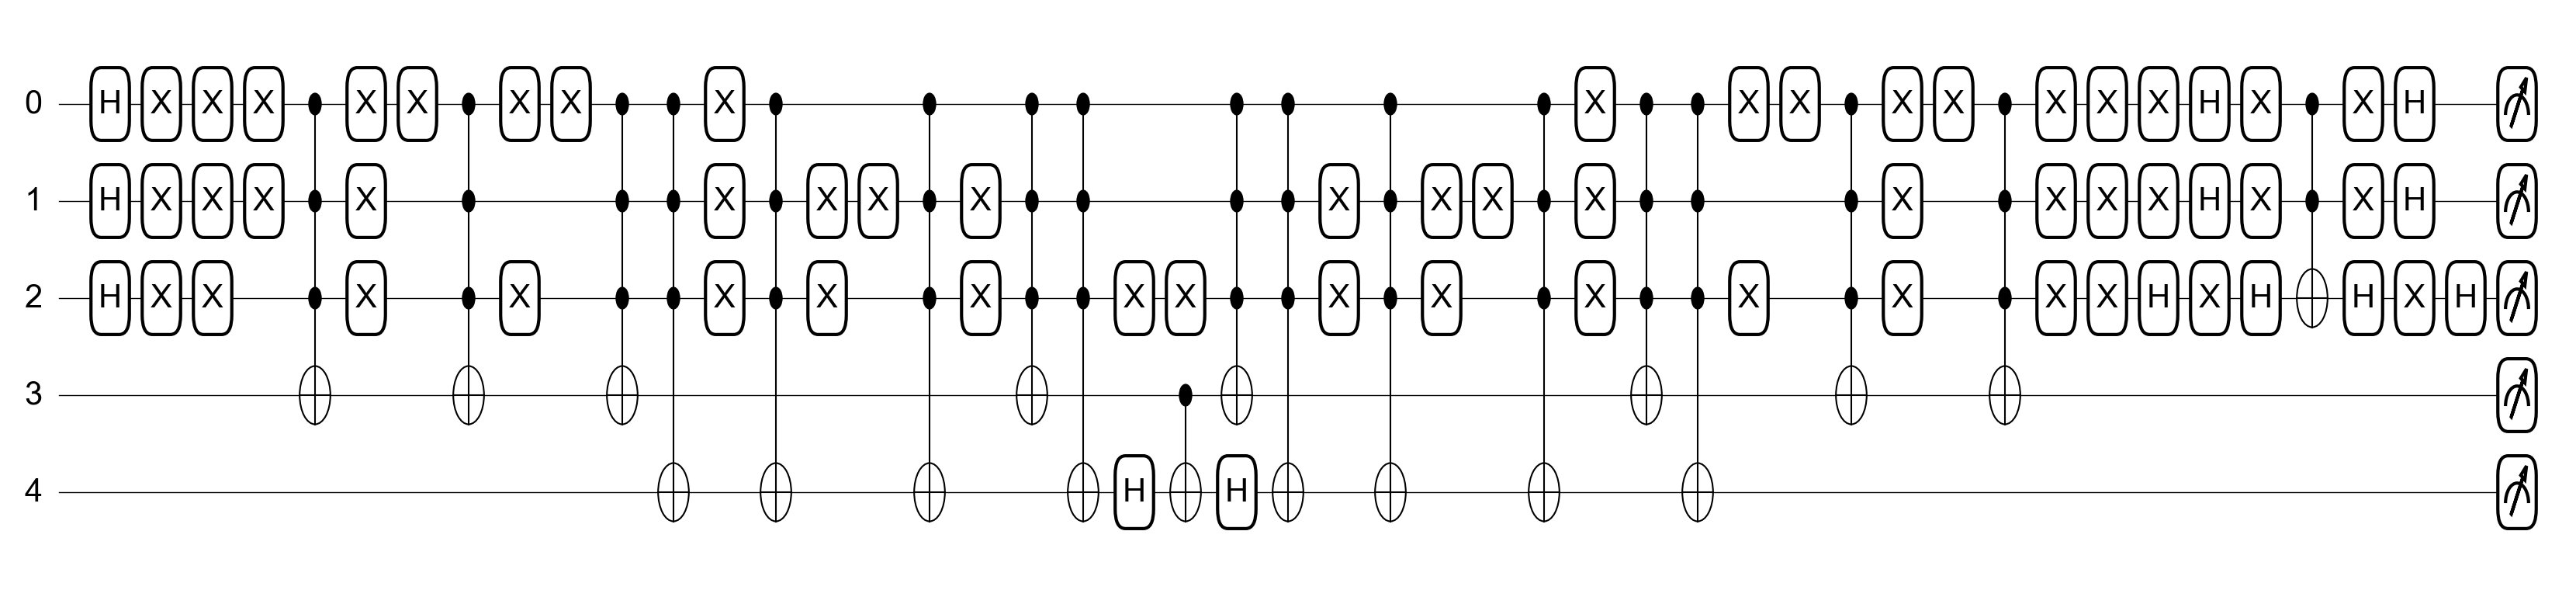

→ Saved: figures/dna/ss_qrom_circuit.pdf


C:\Users\mruna\AppData\Local\Temp\ipykernel_25160\2906484112.py:150: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0.5)


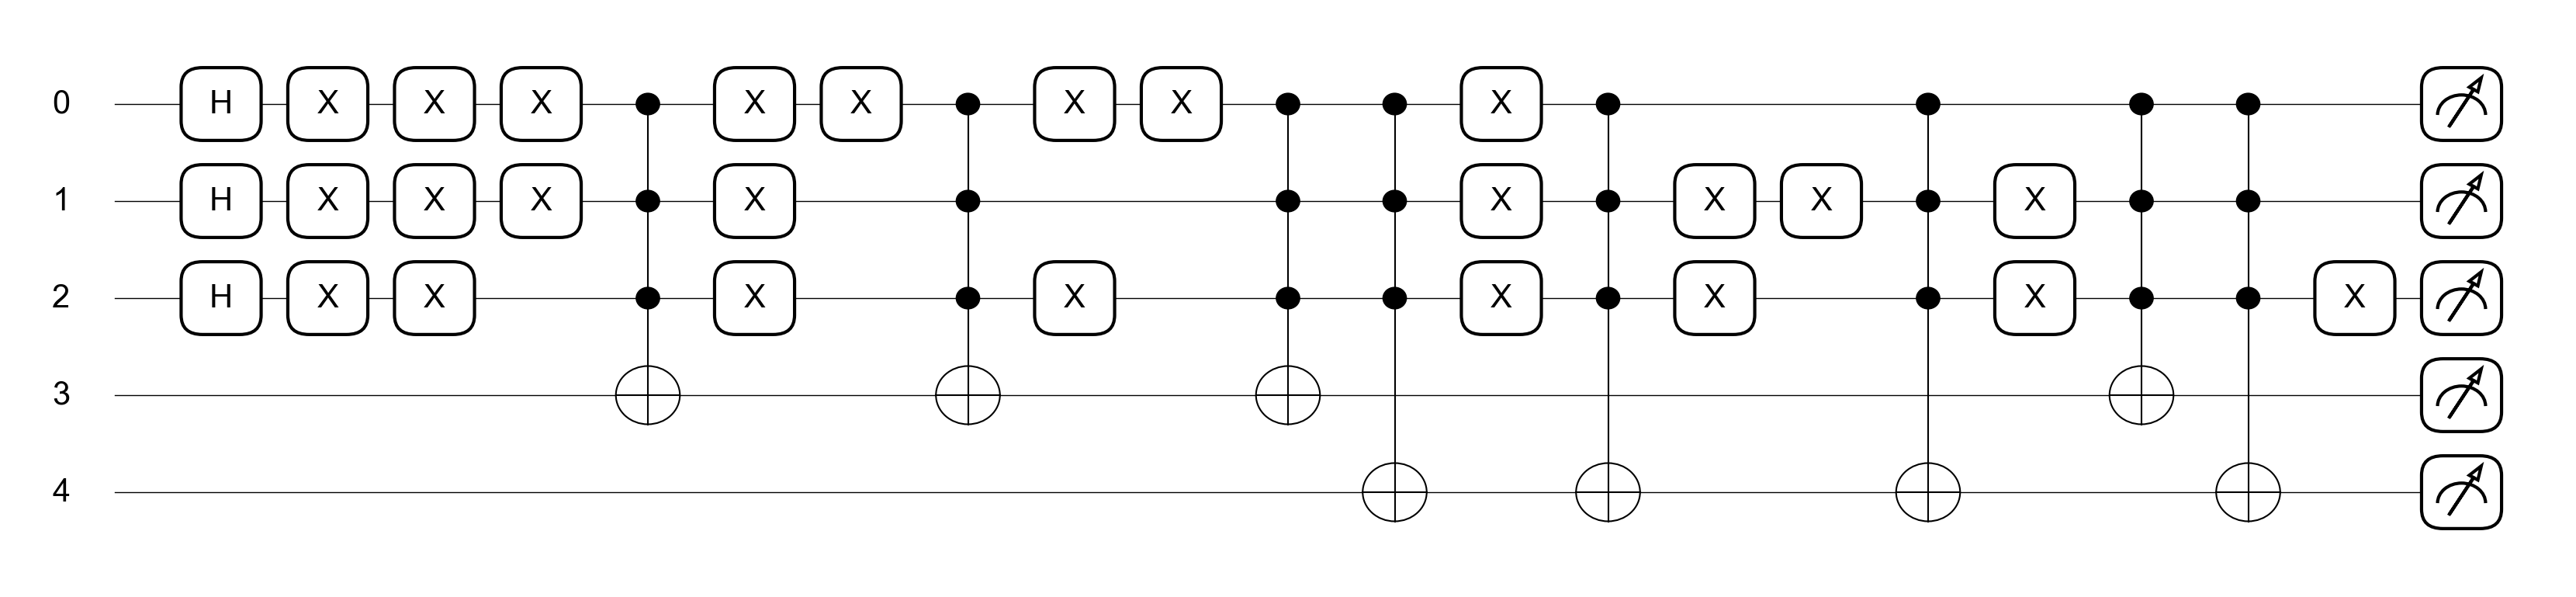

→ Saved: figures/dna/ss_oracle_circuit.pdf


C:\Users\mruna\AppData\Local\Temp\ipykernel_25160\2906484112.py:150: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0.5)


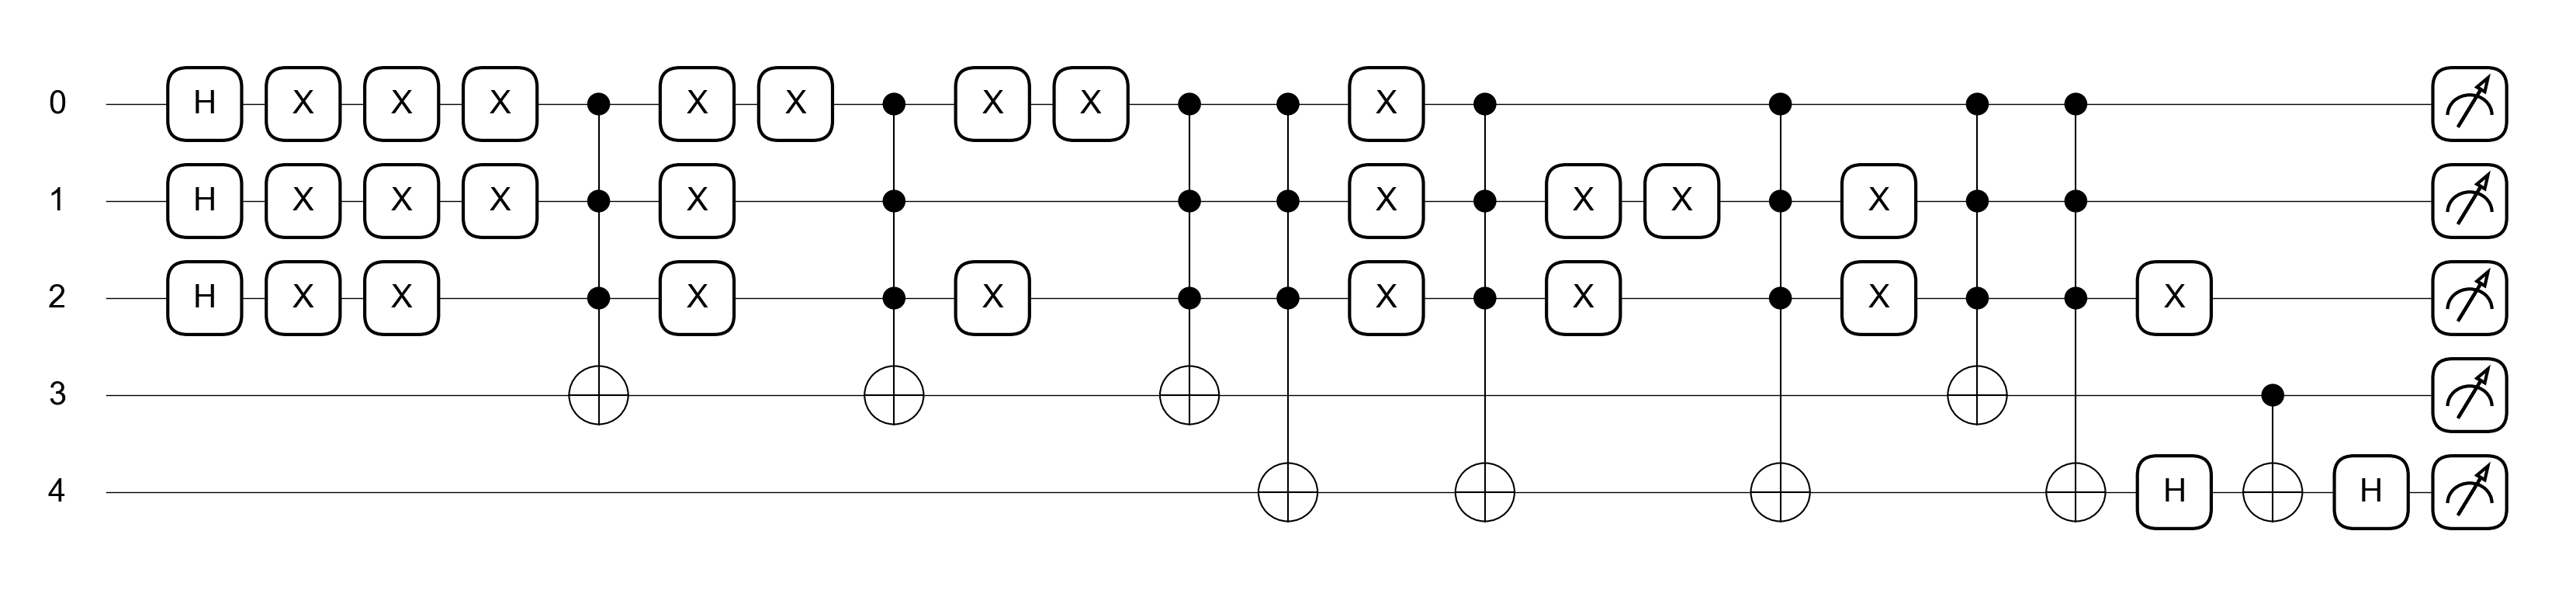

→ Saved: figures/dna/ss_diffuser_circuit.pdf


C:\Users\mruna\AppData\Local\Temp\ipykernel_25160\2906484112.py:150: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0.5)


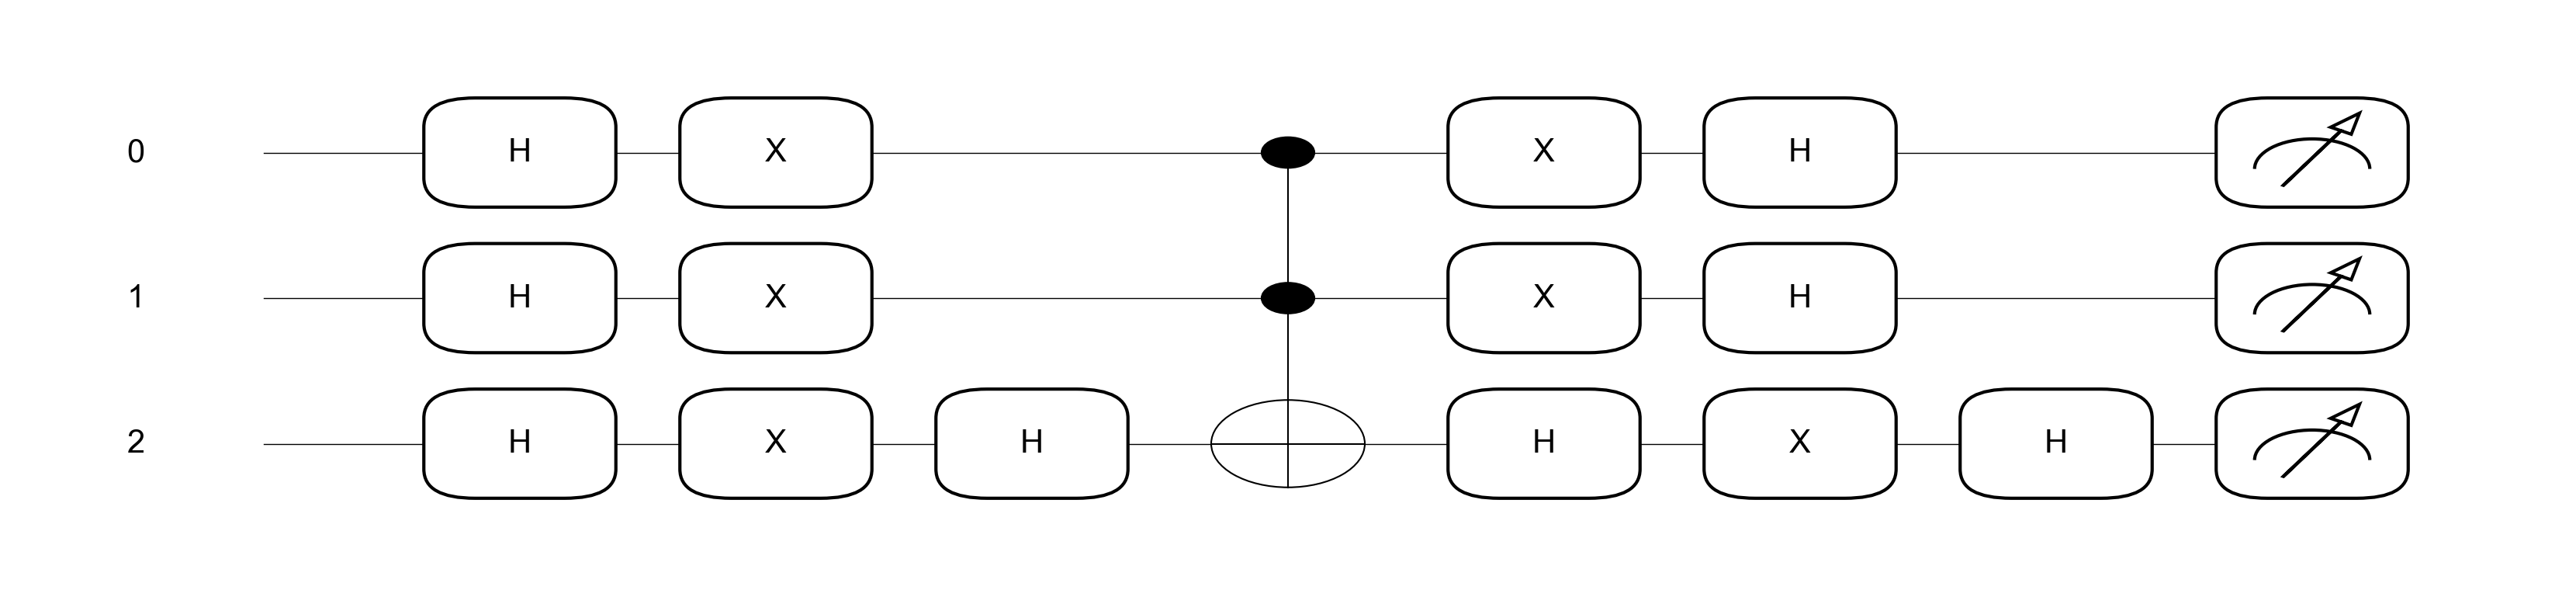

In [59]:
gs.draw_full_circuit()
gs.draw_qrom()
gs.draw_oracle()
gs.draw_diffuser()